# Taller teórico - práctico sobre redes neuronales

Dr. Héctor Henríquez Leighton



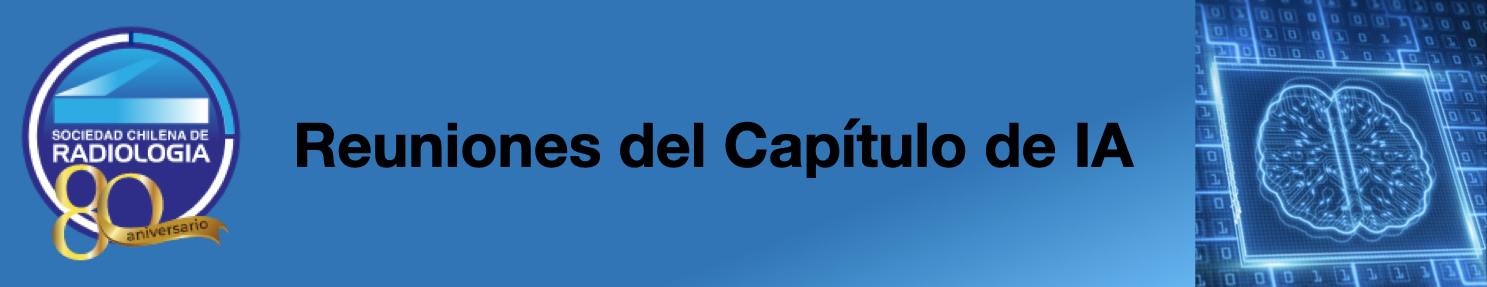

In [ ]:
!pip3 install keras-visualizer

In [ ]:
## Herramientas generales
import numpy as np 
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cv2
import os
import imutils


## Construcción de modelos
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.vgg16 import VGG16 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input,concatenate, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.datasets import mnist
from keras_visualizer import visualizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def transformNumber(img, dim, p):
  """
  INPUT: Recibe la imagen, las dimensiones de la imagen de salida y la
  probabilidad de no transformación.
  Genera transformaciones aleatorias en la imagen, con desplazamiento, rotación,
  aumento o disminución de tamaño.
  OUTPUT: Imagen transformada.
  """
  process = np.random.choice(['transform', 'not-transform'], 1, p=[1-p, p])
  if(process == 'transform'):
    fondo = np.zeros((dim,dim))
    ## Elección aleatoria de ángulo de rotación y tamaño
    angle = np.random.randint(0,350)
    size = np.random.randint(25,35)

    img_res = cv2.resize(img, (size, size),interpolation = cv2.INTER_LINEAR)
    img_rot = imutils.rotate(img_res, angle)

    y_start = np.random.randint(0, fondo.shape[0] - img_rot.shape[0])
    x_start = np.random.randint(0, fondo.shape[0] - img_rot.shape[1])
    fondo[y_start:y_start+img_rot.shape[1], x_start:x_start + img_rot.shape[0]] = img_rot
    fondo = cv2.resize(fondo, (28, 28),interpolation = cv2.INTER_LINEAR)
  else:
    fondo = img
  return(fondo)

def MapaActivacion(img_tensor, modelo):
    
    grad_model = tf.keras.models.Model(
          [model.inputs], [model.get_layer('conv2d_1').output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([img_tensor])
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap_array =np.array(heatmap)
    heatmap_resize = cv2.resize(heatmap_array, (img_tensor.shape[2],img_tensor.shape[1]),
               interpolation = cv2.INTER_CUBIC)
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resize), cv2.COLORMAP_HSV) 

  
    return(heatmap_array, heatmap_color)

In [ ]:
## carga de datos MNIST

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
## Visualización de MNIST
ROWS = 5
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.randint(0, X_train.shape[0])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i,:,:], cmap='gray')
        axes1[j][k].set_title("number: {}".format(y_train[i]), size=8)
      

In [ ]:
## Preprocesamiento de datos MNIST
num_classes = 10
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Ejemplos de etiquetas:
print(y_train[0:10])

In [ ]:
X_train_flatten = np.zeros((X_train.shape[0], 784))

for i in range(X_train.shape[0]):
  X_train_flatten[i,:] = X_train[i].reshape(784)

X_test_flatten = np.zeros((X_test.shape[0], 784))

for i in range(X_test.shape[0]):
  X_test_flatten[i,:] = X_test[i].reshape(784)

In [ ]:
print(X_train_flatten.shape)
print(X_test_flatten.shape)

In [ ]:
## Creación de modelo fully connected layer
tf.keras.backend.clear_session()

model_dense = Sequential()
model_dense.add(Dense(16, input_shape=(784,)))
model_dense.add(Dense(32, activation='relu'))

## Aplanado del vector y clasificación:
model_dense.add(Flatten())
model_dense.add(Dense(num_classes, activation='softmax'))

model_dense.summary()

In [ ]:
## Visualizar red neuronal fully connected
visualizer(model_dense, file_name='mi_primera_red_neuronal_fully_connected', file_format='png', view=False, settings=None)

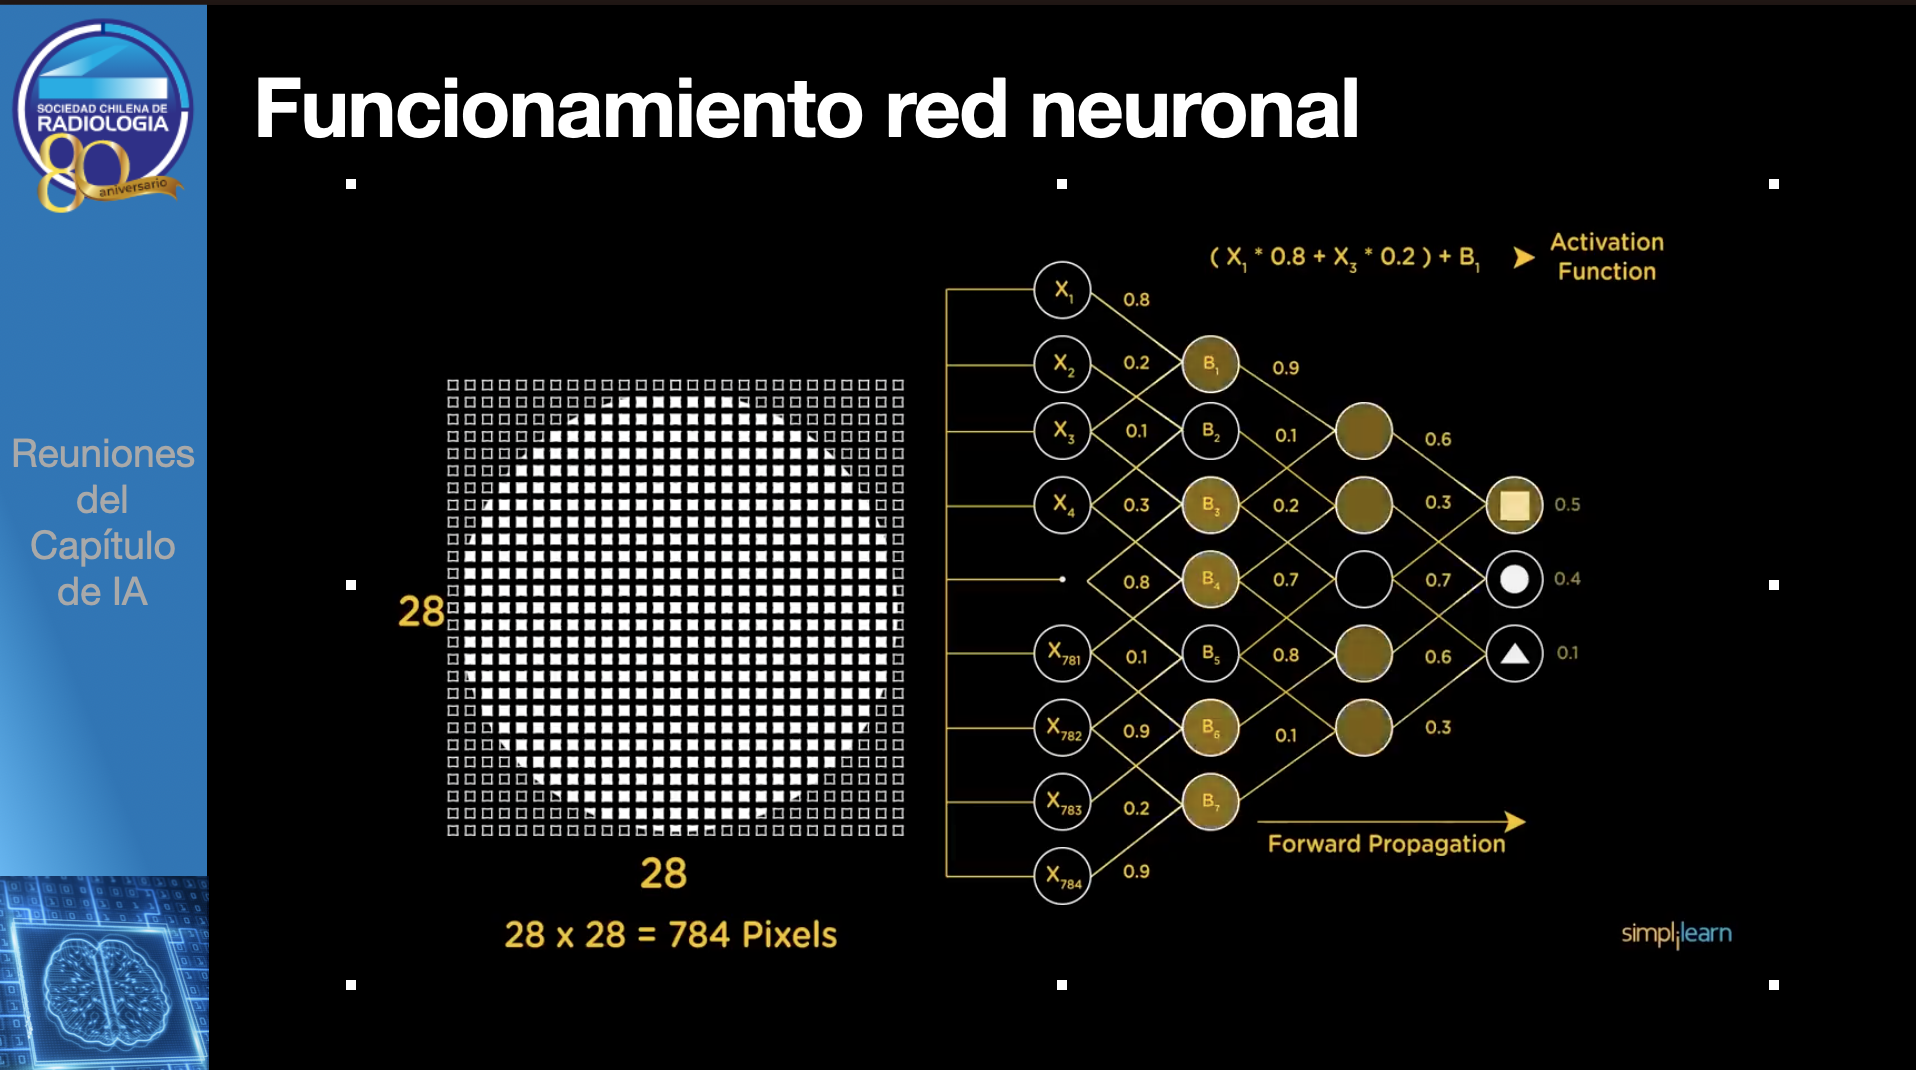

In [ ]:
## Compilado y entrenamiento

EPOCHS = 10
BATCH_SIZE = 32
LR = 0.005
model_dense.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics='accuracy')

history = model_dense.fit(X_train_flatten, y_train, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE, 
                validation_data=(X_test_flatten, y_test), shuffle= True)

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy', color='salmon')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='dodgerblue')
plt.title('Training and validation accuracy Fully Connected Model')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss Fully Connected Model')
plt.legend()
plt.show()

In [ ]:
### Métricas de rendimiento por cada número
pred_scores = model_dense.predict(X_test_flatten)
y_pred = np.where(pred_scores > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

## Números de MNIST con variabilidad de tamaño y posición

In [ ]:
X_train_mod = []
X_test_mod = []

for i in range(X_train.shape[0]):
  X_train_mod.append(transformNumber(X_train[i],50,0.2))


for i in range(X_test.shape[0]):
  X_test_mod.append(transformNumber(X_test[i],50, 0.2))

X_train_mod = np.array(X_train_mod)  
X_test_mod = np.array(X_test_mod)  

# Visualización de MNIST modificados
ROWS = 5
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.randint(0, X_train_mod.shape[0])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train_mod[i,:,:], cmap='gray')
      

In [ ]:
## Aplanado de imágenes

X_train_flatten = np.zeros((X_train_mod.shape[0], X_train_mod.shape[1]* X_train_mod.shape[2]))

for i in range(X_train_mod.shape[0]):
  X_train_flatten[i,:] = X_train_mod[i].reshape(X_train_mod.shape[1]* X_train_mod.shape[2])

X_test_flatten = np.zeros((X_test_mod.shape[0], X_test_mod.shape[1]* X_test_mod.shape[2]))

for i in range(X_test_mod.shape[0]):
  X_test_flatten[i,:] = X_test_mod[i].reshape(X_test_mod.shape[1]* X_test_mod.shape[2])

print(X_train_flatten.shape)
print(X_test_flatten.shape)

In [ ]:
pred_scores = model_dense.predict(X_test_flatten)
y_pred = np.where(pred_scores > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

In [ ]:
## Creación de modelo fully connected layer
tf.keras.backend.clear_session()

model_dense = Sequential()
model_dense.add(Dense(16, input_shape=(784,)))
model_dense.add(Dense(32, activation='relu'))

## Aplanado del vector y clasificación:
model_dense.add(Flatten())
model_dense.add(Dense(num_classes, activation='softmax'))

model_dense.summary()

In [ ]:
## Compilado y entrenamiento

EPOCHS = 20
BATCH_SIZE = 64
LR = 0.005
model_dense.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics='accuracy')

history = model_dense.fit(X_train_flatten, y_train, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE, 
                validation_data=(X_test_flatten, y_test), shuffle= True)

In [ ]:
pred_scores = model_dense.predict(X_test_flatten)
y_pred = np.where(pred_scores > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

## Construcción y entrenamiento de Red Convolucional

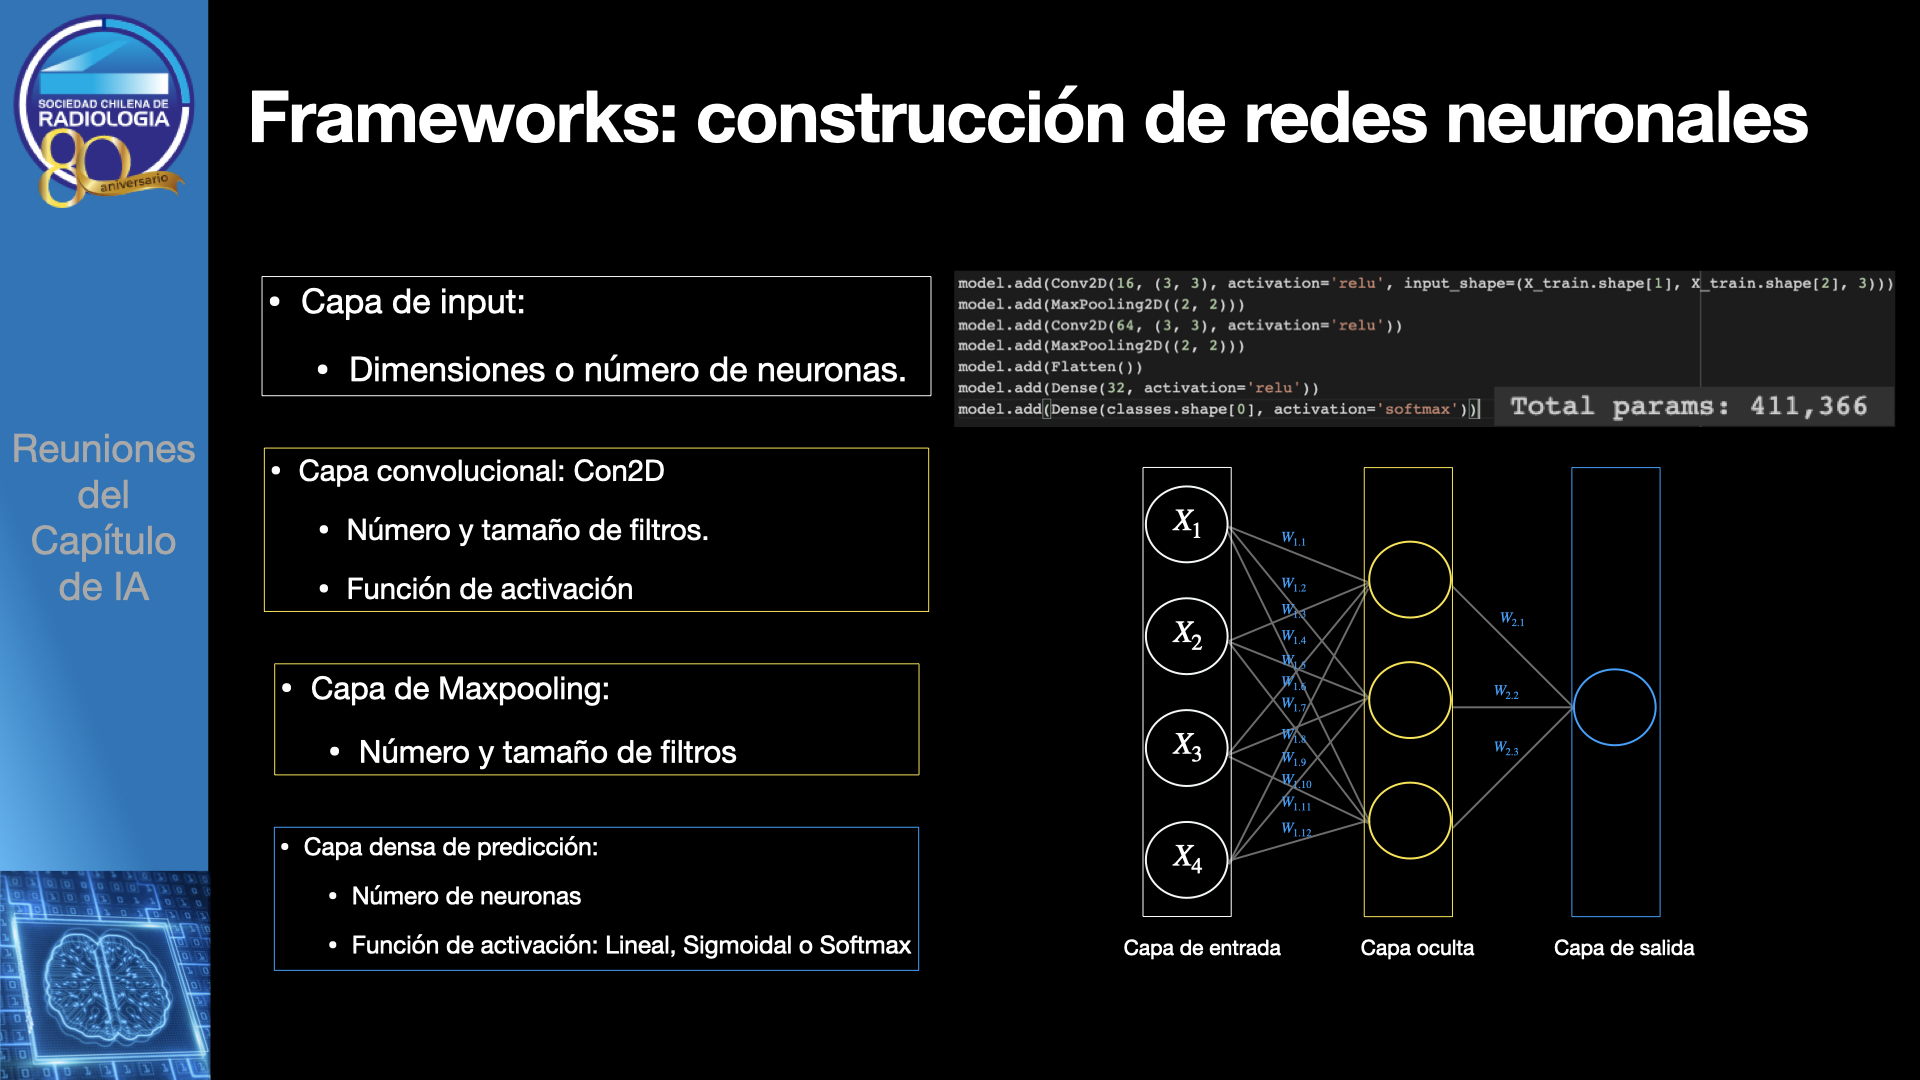

In [ ]:
## Modelo Convolucional

tf.keras.backend.clear_session()

model = Sequential()

## Primera capa: Input y primera convolución:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(X_train_mod.shape[1], X_train_mod.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))

## Segunda capa convolucional:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout((0.15)))

## Aplanado del vector y clasificación:
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout((0.1)))
model.add(Dense(10, activation='softmax'))

## Muestra resumen del modelo:
model.summary()

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
LR = 0.005

### Configuración de Callbacks:
def scheduler(epoch, learning_rate):
    if epoch < 3:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.05)
lr_scheduler = LearningRateScheduler(scheduler)

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Compilado y entrenamiento
model.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics='accuracy')

history = model.fit(X_train_mod, y_train, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE, 
                validation_data=(X_test_mod, y_test), shuffle= True,
                callbacks=[model_checkpoint_callback,lr_scheduler])


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy', color='salmon')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='dodgerblue')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
pred_scores = model.predict(X_test_mod)
y_pred = np.where(pred_scores > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

In [ ]:
numero = np.random.randint(0, X_test_mod.shape[0])
print('caso Test:', numero)

img = X_test_mod[numero]
img_tensor = np.expand_dims(img, axis=0) 

prediccion = model.predict(img_tensor)
print("Predicción:", np.argmax(prediccion))
print("Respuesta correcta:",np.argmax(y_test[numero]) )
print(". " *3)

heatmap_array, heatmap_resized = MapaActivacion(img_tensor, model)

img_3channel = np.stack((img.reshape(28,28),)*3, axis=-1)


f = plt.figure(figsize=(7,7), frameon=False)

f.add_subplot(1, 3, 1)
plt.title("imagen original")
plt.imshow(img, cmap='gray_r')

f.add_subplot(1, 3, 2)
plt.title("Mapa de Activación")
plt.imshow(heatmap_array, cmap='gnuplot', interpolation='gaussian')

f.add_subplot(1, 3, 3)
plt.title("Fusión")
plt.imshow(img, cmap='gray_r')
plt.imshow(heatmap_resized, cmap='gnuplot',alpha=0.5)

plt.show()